# PA004 - HEALTH INSURANCE CROS-SELL

## Final Version Cycle 1

## 0 - IMPORTS AND FUNCTIONS

In [1]:
# Data Analysis and Data Manipulation Libraries
import pandas                  as pd
import numpy                   as np
import seaborn                 as sns
import scikitplot              as skplt
import matplotlib.pyplot       as plt
import plotly.express          as px
import inflection
from ydata_profiling           import ProfileReport 

# Machine Learning Models
import optuna
from sklearn.linear_model      import LogisticRegression
from xgboost                   import XGBClassifier
from sklearn.neighbors         import KNeighborsClassifier

from sklearn                   import model_selection as ms
from sklearn.model_selection   import  KFold, StratifiedKFold
from sklearn                   import pipeline

# Metrics and Performance
from sklearn.metrics           import precision_score, roc_auc_score, roc_curve,auc, recall_score
from sklearn.metrics           import precision_recall_curve

# Data Transformer
from feature_engine.encoding       import CountFrequencyEncoder

# Dysplay
%matplotlib inline
from IPython.core.display    import HTML
from IPython.display         import Image

import warnings
warnings.filterwarnings( 'ignore' )

### 0.1 - HELPER FUNCTIONS

In [2]:
def ml_performance( model_name, precision_atK, recall_atK):
        
        return pd.DataFrame( {'Model Name': model_name,
                              'Precision_at_K': precision_atK,
                              'Recall_at_K': recall_atK}, index=[0] )

def precision_at_k_cv(y_true, proba_predictions, k):
    # Sort the estimated probabilities in descending order.
    sorted_indices = np.argsort(proba_predictions[:, 1])[::-1]
    top_k_indices = sorted_indices[:k]
    
    # Convert the probabilities into binary labels using the top k.
    binary_predictions = np.zeros_like(y_true)
    binary_predictions[top_k_indices] = 1
    
    # Calculate precision at k.
    precision_at_k = precision_score(y_true, binary_predictions)
    
    return precision_at_k

def recall_at_k_cv(y_true, proba_predictions, k):
    # Sort the estimated probabilities in descending order.
    sorted_indices = np.argsort(proba_predictions[:, 1])[::-1]
    top_k_indices = sorted_indices[:k]
    
    # Convert the probabilities into binary labels using the top k.
    binary_predictions = np.zeros_like(y_true)
    binary_predictions[top_k_indices] = 1
    
    # Calculate recall at k
    recall_at_k = recall_score(y_true, binary_predictions)
    
    return recall_at_k

def cross_validation(kfold, modelName, model, X, y, at_k):
    
    # Number of folds
    fold=ms.StratifiedKFold(n_splits = kfold, shuffle=True, random_state=42)
    
    # Performance variables
    precision_list = []
    recall_list = []
    cv_performance = {}
    
    for train_cv,val_cv in fold.split(X, y):
        
        # Separating train and validation dataset for each kfold
        # training data
        x_train_fold = X.iloc[train_cv]
        x_train_fold = x_train_fold
        
        y_train_fold = y.iloc[train_cv]
        y_train_fold = y_train_fold
        
        # validation data
        x_val_fold = X.iloc[val_cv]
        x_val_fold = x_val_fold
        
        y_val_fold = y.iloc[val_cv]
        y_val_fold = y_val_fold
        
        # fitting the model
        model_fitted = model.fit(x_train_fold, y_train_fold)
        
        # getting the prediction probability
        x_val_fold['response'] = y_val_fold
        val_scored = prediction_score(model_fitted, x_val_fold)
        
        # Getting precision and recall at k
        precision = val_scored.loc[at_k, 'precision_at_k']
        recall = val_scored.loc[at_k, 'recall_at_k']
        
        precision_list.append(precision)
        recall_list.append(recall)
        
    # calculating the mean and std performance of all kfolds
    precision_cv = np.round(np.mean(precision_list),4).astype(float)
    std_precision_cv = '+/-' + np.round(np.std(precision_list),4).astype(str)
    recall_cv = np.round(np.mean(recall_list),4).astype(float)
    std_recall_cv = ' +/- ' + np.round(np.std(recall_list),4).astype(str)
        
    cv_performance[modelName] = [precision_cv, std_precision_cv, recall_cv, std_recall_cv]
    model_performance_cv = pd.DataFrame(cv_performance, index=['precision_at_k', 'std_precision', 'recall_at_k', 'std_recall'])

    return model_performance_cv

def prediction_score(model, data):
    # Separating train and validation dataset for each kfold
    x_train = data.drop(columns=['response'])
    y_train = data['response']
    
    # prediction probability (score)
    yhat_proba = model.predict_proba(x_train)[:, 1].tolist()
    
    # merging score to dataset
    data_scored = data.copy()
    data_scored['score'] = yhat_proba
    
    # sort
    data_scored = data_scored.sort_values('score', ascending=False)
    
    # precision and recall
    data_scored = data_scored.reset_index(drop=True)
    data_scored['n_samples'] = data_scored.index + 1
    data_scored['precision_at_k'] = data_scored['response'].cumsum() / data_scored['n_samples']
    data_scored['recall_at_k'] = data_scored['response'].cumsum() / data_scored['response'].sum()
    
    return data_scored



In [169]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [18, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
   
    sns.set()
jupyter_settings()

## 1 - DATAS

In [3]:
# Train Datas - Windows
df_raw = pd.read_csv('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/data/raw/data.csv')

### 1.1 - DATASET SPLIT

In [4]:
# Split dataset into train, test and validation datasets
X = df_raw.drop( ['response'], axis=1 )
y = df_raw['response'].copy()
x_train, x_valid, y_train, y_valid = ms.train_test_split( X, y, test_size=0.20, random_state=42 )
x_train, x_test, y_train, y_test   = ms.train_test_split( x_train, y_train, test_size=0.25, shuffle=True, random_state=42 )

print(f" x_train: {x_train.shape}\n y_train: {y_train.shape}\n x_valid: {x_valid.shape}\n y_valid: {y_valid.shape}\n x_test: {x_test.shape}\n y_test: {y_test.shape}\n")

 x_train: (228665, 11)
 y_train: (228665,)
 x_valid: (76222, 11)
 y_valid: (76222,)
 x_test: (76222, 11)
 y_test: (76222,)



### 1.2 - DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()

In [6]:
#prof = ProfileReport(df1)
#prof.to_file(output_file='data_descriptive.html')

In [7]:
# Data Dimensions
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 381109
Number of Cols: 12


In [8]:
# Data Types
df1.dtypes

id                       int64
gender                  object
age                      int64
region_code              int64
policy_sales_channel     int64
driving_license          int64
vehicle_age             object
vehicle_damage          object
previously_insured       int64
annual_premium           int64
vintage                  int64
response                 int64
dtype: object

In [9]:
# Check NAN Values
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

### 1.3 - DATA DESCRIPTIVE

In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    381109 non-null  int64 
 1   gender                381109 non-null  object
 2   age                   381109 non-null  int64 
 3   region_code           381109 non-null  int64 
 4   policy_sales_channel  381109 non-null  int64 
 5   driving_license       381109 non-null  int64 
 6   vehicle_age           381109 non-null  object
 7   vehicle_damage        381109 non-null  object
 8   previously_insured    381109 non-null  int64 
 9   annual_premium        381109 non-null  int64 
 10  vintage               381109 non-null  int64 
 11  response              381109 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 34.9+ MB


In [11]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
id,381109.0,190555.000000,110016.836208,1.0,95278.0,190555.0,285832.0,381109.0
age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0
region_code,381109.0,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0
policy_sales_channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0
driving_license,381109.0,0.997869,0.046110,0.0,1.0,1.0,1.0,1.0
previously_insured,381109.0,0.458210,0.498251,0.0,0.0,0.0,1.0,1.0
annual_premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0
vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0
response,381109.0,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0


In [167]:
# Select columns where the content is different 0 or 1.
# numerical features
#num_attributes = df1.select_dtypes(include=['int64', 'float64'])
num_attributes = df1[['id','age','region_code','policy_sales_channel','annual_premium','vintage']]
# categorical features
#cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])
cat_attributes = df1[['gender','vehicle_age']]

array([[<AxesSubplot: title={'center': 'id'}>,
        <AxesSubplot: title={'center': 'age'}>],
       [<AxesSubplot: title={'center': 'region_code'}>,
        <AxesSubplot: title={'center': 'policy_sales_channel'}>],
       [<AxesSubplot: title={'center': 'annual_premium'}>,
        <AxesSubplot: title={'center': 'vintage'}>]], dtype=object)

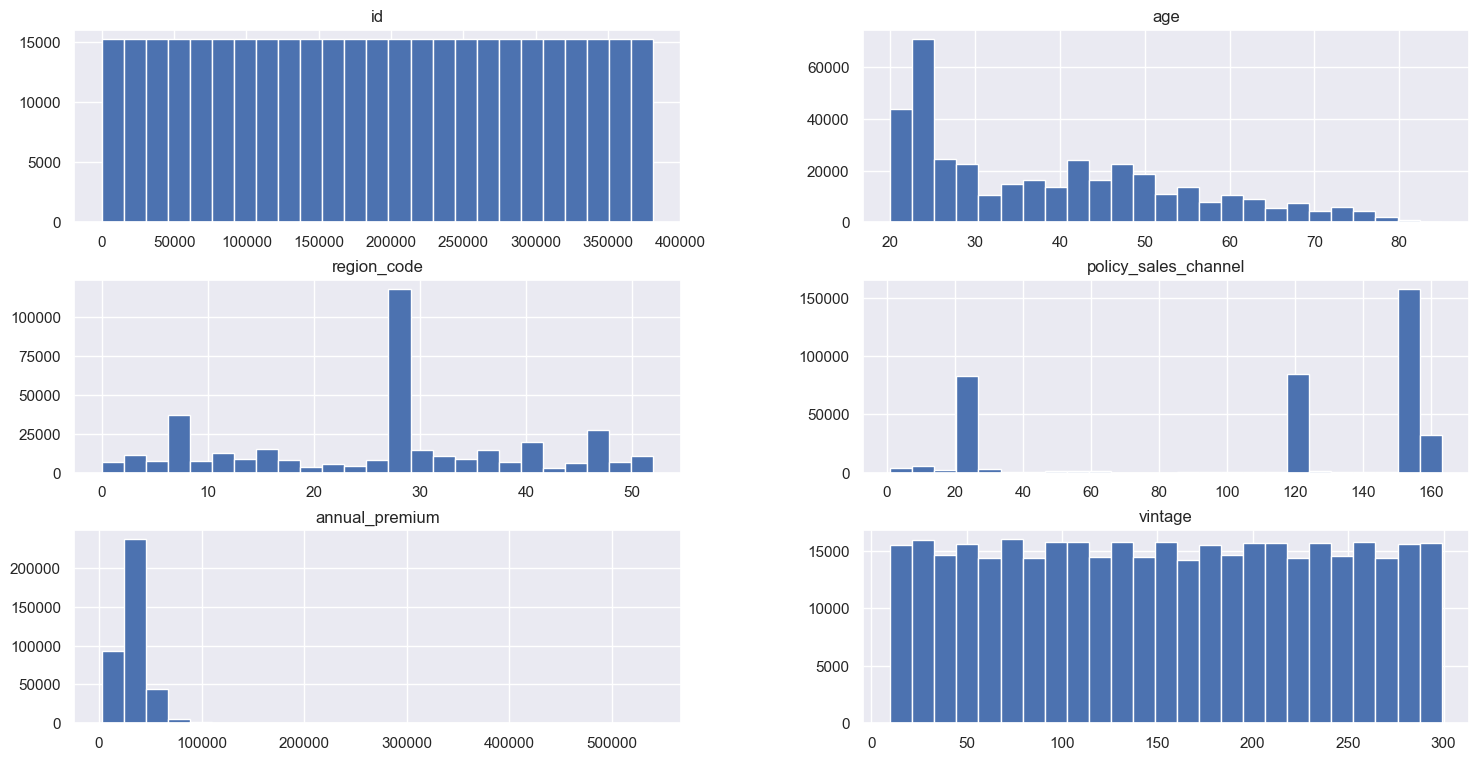

In [168]:
num_attributes.hist(bins=25)

In [15]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenar
m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,-8.071174e-18,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
3,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
4,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
5,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688


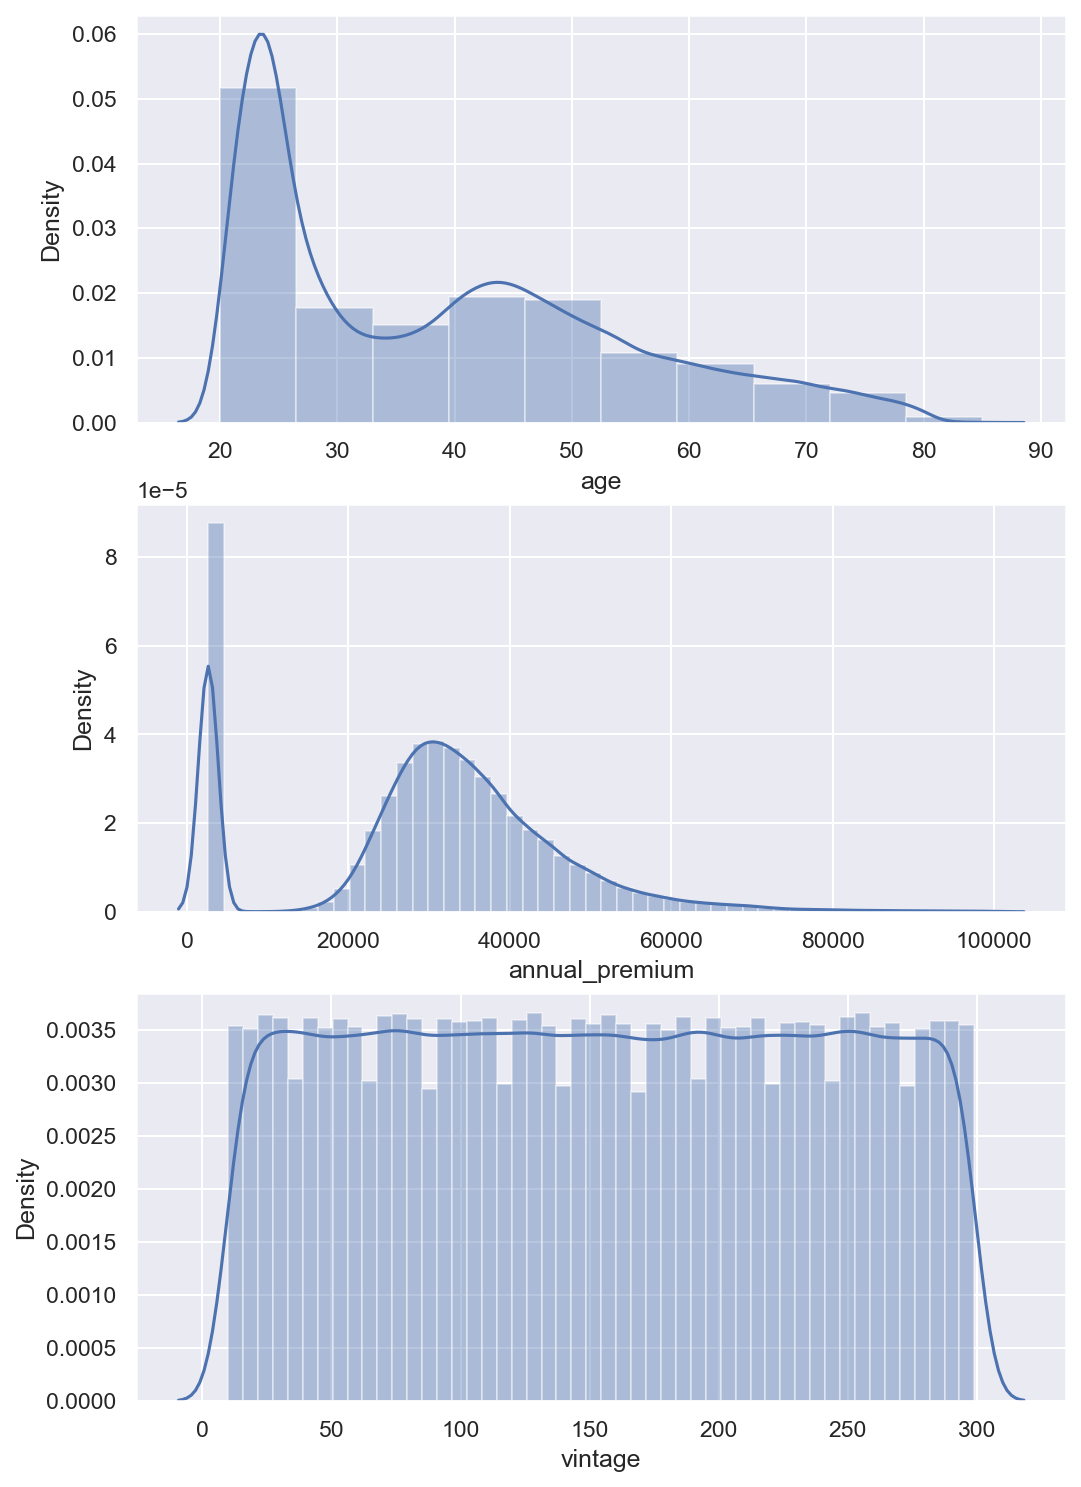

In [71]:
# Looking at the distribuition of the following variables.
fig, axs = plt.subplots(3, figsize = (8, 12), dpi=150)
sns.distplot(df1['age'], ax=axs[0], bins=10)
sns.distplot(df1[df1['annual_premium']<100000]['annual_premium'], ax=axs[1])
sns.distplot(df1['vintage'], ax=axs[2]);

<AxesSubplot: xlabel='vehicle_damage', ylabel='count'>

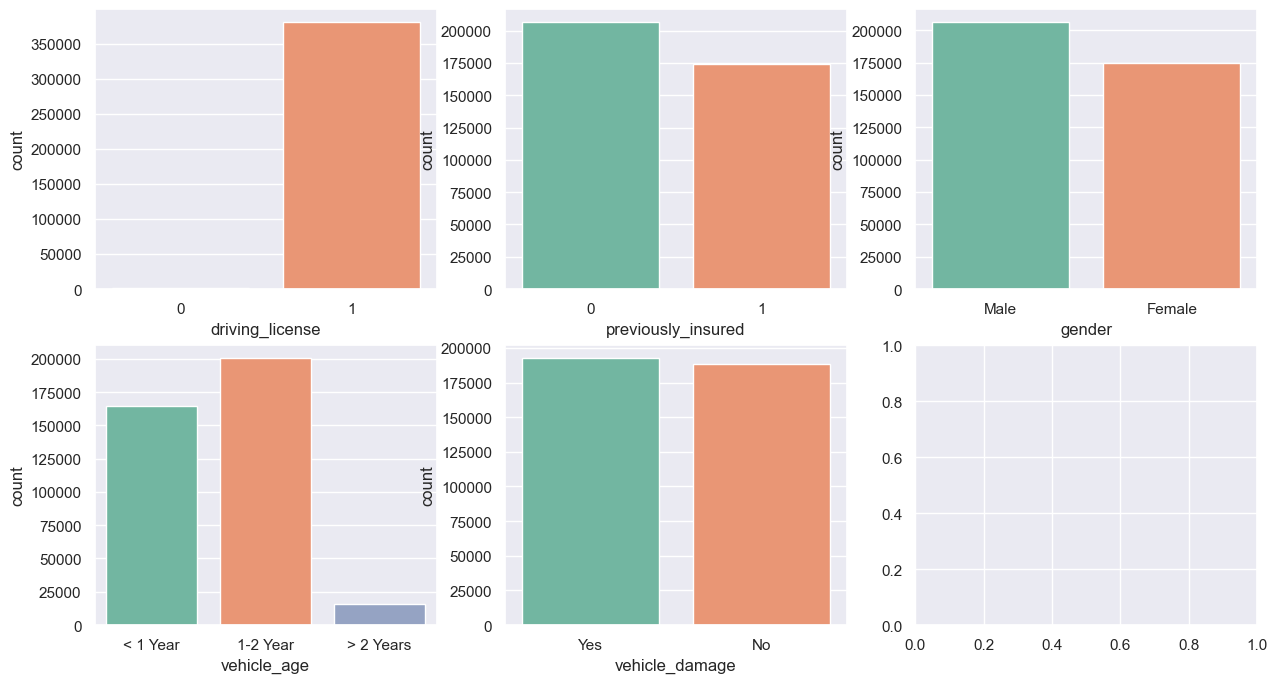

In [44]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize= (15, 8))

sns.countplot(x = 'driving_license', palette = 'Set2', data=df1, ax=axs[0][0])
sns.countplot(x = 'previously_insured', palette = 'Set2', data=df1, ax=axs[0][1])
sns.countplot(x = 'gender', palette = 'Set2', data=df1, ax=axs[0][2])
sns.countplot(x = 'vehicle_age', palette = 'Set2', data=df1, ax=axs[1][0])
sns.countplot(x = 'vehicle_damage', palette = 'Set2', data=df1, ax=axs[1][1])

<AxesSubplot: xlabel='region_code', ylabel='count'>

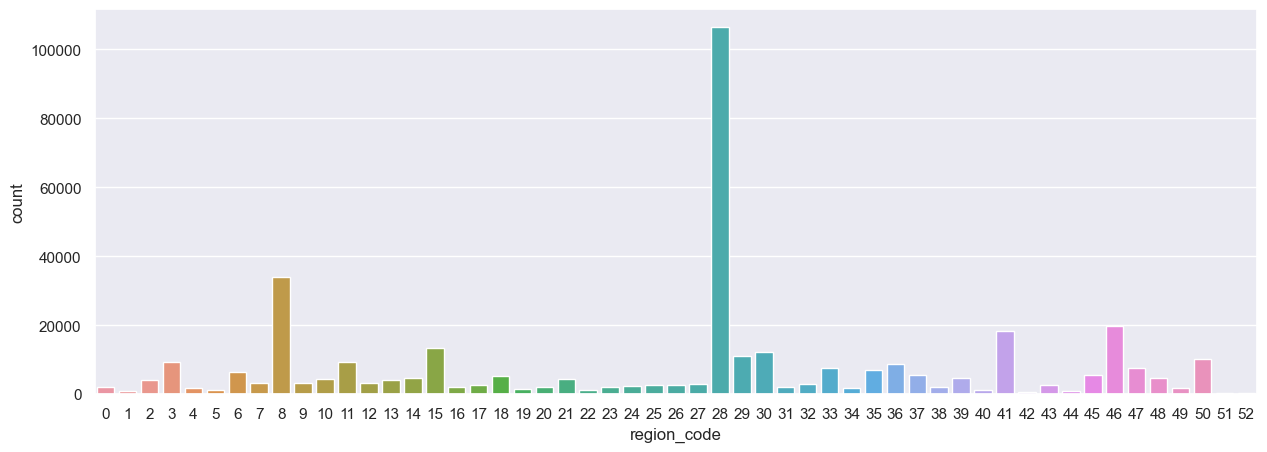

In [45]:
fig = plt.subplots(figsize = (15,5))
sns.countplot(x='region_code', data=df1)

<AxesSubplot: xlabel='policy_sales_channel', ylabel='index'>

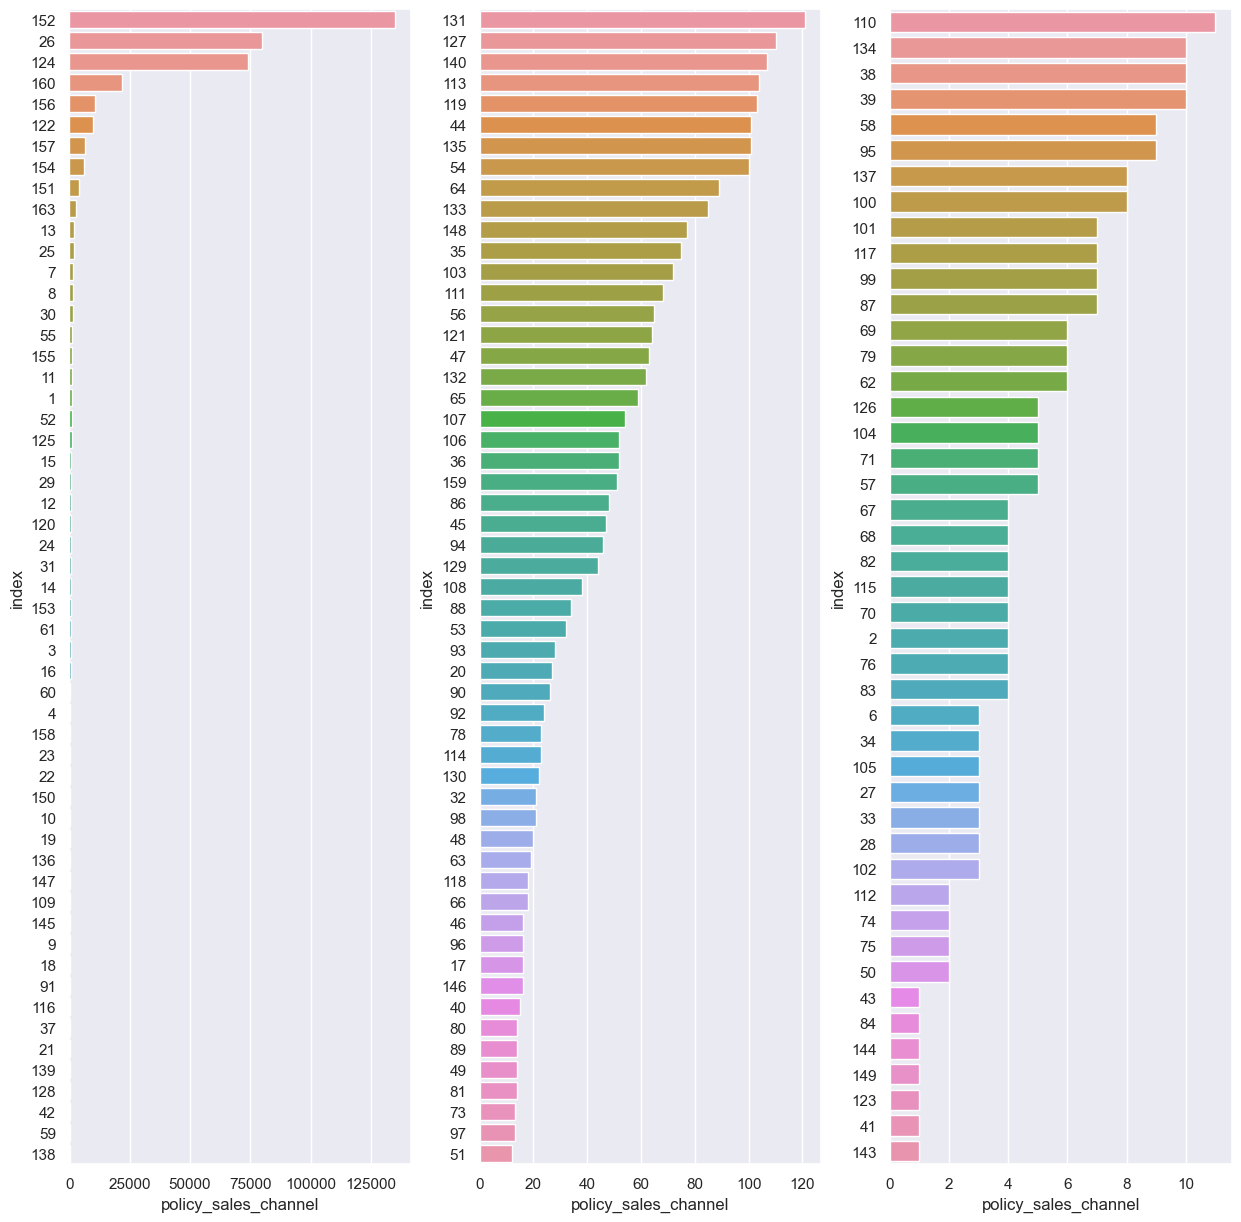

In [46]:
policy_1 = df1['policy_sales_channel'].value_counts().iloc[0:55]
policy_1 = policy_1.reset_index()
policy_2 = df1['policy_sales_channel'].value_counts().iloc[55:110]
policy_2 = policy_2.reset_index()
policy_3 = df1['policy_sales_channel'].value_counts().iloc[110:156]
policy_3 = policy_3.reset_index()

fig, axs = plt.subplots(ncols=3, figsize=(15,15))
sns.barplot(y='index', x='policy_sales_channel', data=policy_1, ax=axs[0], orient='h', order=policy_1['index'])
sns.barplot(y='index', x='policy_sales_channel', data=policy_2, ax=axs[1], orient='h', order=policy_2['index'])
sns.barplot(y='index', x='policy_sales_channel', data=policy_3, ax=axs[2], orient='h', order=policy_3['index'])

## 2 - FEATURE ENGINEERING

In [47]:
df2 = df1.copy()

# Ajustando coluna vehicle_age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 1 if (x == '< 1 Year') else
                                                        2 if (x == '1-2 Year') else
                                                        3)
# Ajustando coluna vehicle_damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if (x == 'Yes') else 0)

## 3 - DATA FILTERING

In [48]:
df3 = df2.copy()

## 4 - EXPLORATORY DATA ANALYSIS (EDA)

In [49]:
df4 = df3.copy()

In [50]:
df4.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11,152,1,1,1,0,23367,249,0
1,13,Female,41,15,14,1,2,0,1,31409,221,0
2,18,Female,25,35,152,1,1,0,1,46622,299,0
3,31,Female,26,8,160,1,1,0,0,2630,136,0
4,39,Male,45,8,124,1,2,1,0,42297,264,0


### 4.1 - UNIVARIATE ANALYSIS

<AxesSubplot: xlabel='vintage', ylabel='Density'>

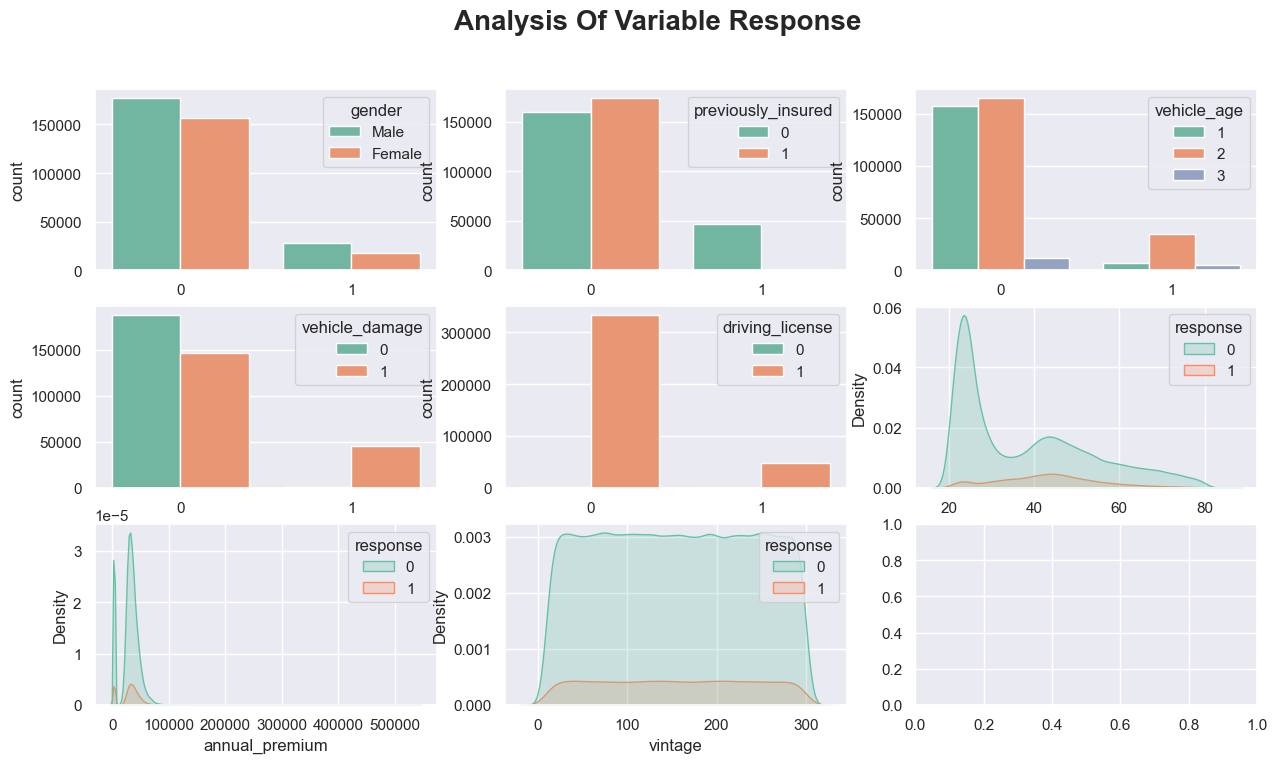

In [51]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize= (15, 8))

plt.suptitle("Analysis Of Variable Response",fontweight="bold", fontsize=20)

sns.countplot(x = 'response', hue = 'gender', palette = 'Set2', data = df4, ax=axs[0][0])
sns.countplot(x = 'response', hue = 'previously_insured', palette = 'Set2', data = df4, ax=axs[0][1])
sns.countplot(x = 'response', hue = 'vehicle_age', palette = 'Set2', data = df4, ax=axs[0][2])
sns.countplot(x = 'response', hue = 'vehicle_damage', palette = 'Set2', data = df4, ax=axs[1][0])
sns.countplot(x = 'response', hue = 'driving_license', palette = 'Set2', data = df4, ax=axs[1][1])
sns.kdeplot(x='age', hue='response', palette = 'Set2', shade=True, data=df4, ax=axs[1][2])
sns.kdeplot(x='annual_premium', hue='response', palette = 'Set2', shade=True, data=df4, ax=axs[2][0])
sns.kdeplot(x='vintage', hue='response', palette = 'Set2', shade=True, data=df4, ax=axs[2][1])

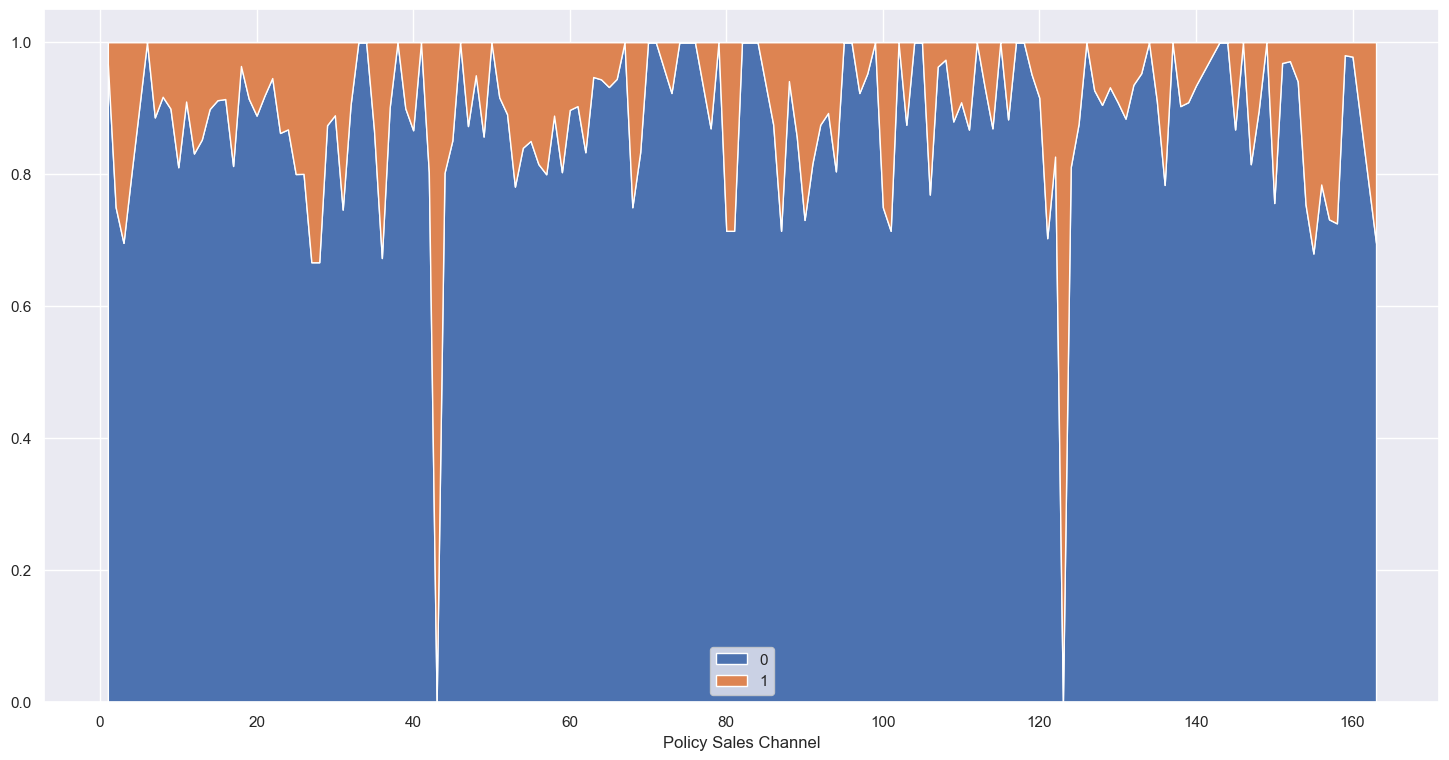

In [52]:
# 'policy_sales_channel'
aux1 = pd.crosstab(df4['policy_sales_channel'], df4['response']).apply(lambda x: x/x.sum(), axis=1).reset_index()

x = aux1['policy_sales_channel']
y1=aux1[0]
y2=aux1[1]

plt.stackplot(x, y1, y2, labels=['0', '1'])
plt.xlabel('Policy Sales Channel')
plt.legend(loc='lower center');

### 4.2 - BIVARIATE ANALYSIS

In [192]:
#1.The interest on purchase the vehicle insurance is greater for customers that damaged their vehicle before and doesn't have insurance. (FALSE)
d1 = df4[( df4['previously_insured'] == 0) & (df4['vehicle_damage'] == 1)]

ax1 = d1[['response','id']].groupby('response').count().reset_index()
ax1['percentage'] = round(ax1['id'] / d1['id'].count()*100)
ax1['response'] = ax1['response'].apply(lambda x: 'No' if (x == 0) else 'Yes')

# Bar chart
fig1 = px.bar(ax1, x='response', 
              y='percentage', 
              color='response', 
              text='percentage', 
              width=1500,
              height=650,
              color_discrete_sequence=px.colors.qualitative.Pastel2)
fig1.update_traces(texttemplate='%{text:.2s}', 
                   textposition='outside')
fig1.update_layout(title_text="Hypothesis 1: Purchase Interest vs Vehicle Damage.", 
                   title_x=0.25,
                   font=dict(size=20))
fig1.show()

Hiphotesys is false once 75% of customers doesn't show interest in buying the vehicle insurance. 

In [195]:
# 2. The interest on purchase the vehicle insurance is greater for woman than men. (FALSE)
ax2 = pd.crosstab(df4['gender'], df4['response'])
ax2['percentage'] = round(ax2[1]/(ax2[0]+ax2[1])*100)

# Creating new dataframe for a bar chart
aux2 = [['Female', 10],['Male',14]]
aux2_df = pd.DataFrame(aux2, columns=['gender','percentage'])

# Bar chart
fig = px.bar(aux2_df, 
             x='gender', 
             y='percentage', 
             color='gender', 
             text='percentage',
             width=1500,
             height=650, 
             color_discrete_sequence=px.colors.qualitative.Pastel2)
fig.update_traces(texttemplate='%{text:.2s}', 
                  textposition='outside')
fig.update_layout(title_text="Hypothesis 2: Purchase Interest vs Gender.", 
                   title_x=0.25,
                   font=dict(size=20))
fig.show()


Hiphotesys is false once 14% of the men show interest in buying the vehicle insurance against 10% of women. 

Hiphotesys is false, according the analysis, the period that the customers are with the company doesn't affect the interest in buying vehicle insurance. 

In [196]:
# 3. The interest on purchase the vehicle insurance is greater for customers that spend less than 30k for annual premium.
aux5 = df4[df4['annual_premium'] > 30000][['id','response']]
aux6 = df4[df4['annual_premium'] <= 30000][['id','response']]

# Percentage of interested customers that spend more than 30k in annual premium
aux16 = aux5[['response','id']].groupby('response').count().reset_index()
aux16['percentage'] = round( aux16['id'] / aux5.shape[0] * 100 )

# Percentage of interested customers that spend less than 30k in annual premium
aux17 = aux6[['response','id']].groupby('response').count().reset_index()
aux17['percentage'] = round( aux17['id'] / aux6.shape[0] * 100 )

# Creating new dataframe for a bar chart
ax4 = [['30k or more in annual premium', 13],['30k or less in annual premium', 11]]
ax4_df = pd.DataFrame(ax4, columns=['annual_premium','percentage'])

# Bar chart
fig = px.bar(ax4_df,
             x='annual_premium',
             y='percentage', 
             color='annual_premium', 
             text='percentage', 
             width=1500, 
             height=650, 
             color_discrete_sequence=px.colors.qualitative.Pastel2)
fig.update_traces(texttemplate='%{text:.2s}',
                  textposition='outside')
fig.update_layout(title_text="Hypothesis 3: Purchase Interest vs Annual Premium",
                  title_x=0.17,
                  font=dict(size=20))
fig.show()

False, customers that spend more than 30k yearly show greter interest on purchase vehicle insurance.

In [197]:
# 4. The interest on purchase the vehicle insurance is greater for customers that have driver license.
aux9 = pd.crosstab(df4['driving_license'], df4['response'])
aux9['percentage'] = round(aux9[1]/(aux9[0]+aux9[1])*100)

# Creating new dataframe for a bar chart
ax9 = [['No', 5 ],['Yes', 12]]
ax9_df = pd.DataFrame(ax9, columns=['driving_license','percentage'])

# Bar chart
fig = px.bar(ax9_df, 
             x='driving_license', 
             y='percentage', 
             color='driving_license', 
             text='percentage', 
             width=1500,
             height=650, 
             color_discrete_sequence=px.colors.qualitative.Pastel2 )
fig.update_traces(texttemplate='%{text:.2s}', 
                  textposition='outside')
fig.update_layout(title_text="Hypothesis 4: Purchase Interest vs Driving License.", 
                  title_x=0.25,
                  font=dict(size=20))
fig.show()

In [198]:
# 5. The interest on purchase the vehicle insurance is greater for customers that have new cars.
aux10 = pd.crosstab(df4['vehicle_age'], df4['response'])
aux10['percentage'] = round(aux10[1]/(aux10[0]+aux10[1])*100)

# Creating new dataframe for a bar chart
ax10 = [['New', 4 ],['Used', 17],['Old', 29]]
ax10_df = pd.DataFrame(ax10, columns=['vehicle_age','percentage'])

# Bar chart
fig = px.bar(ax10_df, 
             x='vehicle_age', 
             y='percentage', 
             color='vehicle_age', 
             text='percentage',
             width=1500,
             height=650,
             color_discrete_sequence=px.colors.qualitative.Pastel2)
fig.update_traces(texttemplate='%{text:.2s}', 
                  textposition='outside')
fig.update_layout(title_text="Hypothesis 5: Purchase Interest vs Vehicle Age.", 
                   title_x=0.25,
                   font=dict(size=20))
fig.show()

In [200]:
# 6. The interest on purchase the vehicle insurance is greater for customers that have new cars and have damaged their vehicles.
aux11 = df4[(df4['vehicle_damage'] == 1 )]
aux12 = pd.crosstab(aux11['vehicle_age'], aux11['response'])
aux12['percentage'] = round(aux12[1]/(aux12[0]+aux12[1])*100)

# Creating new dataframe for a bar chart
ax11 = [['New', 14 ],['Used', 27],['Old', 29]]
ax11_df = pd.DataFrame(ax11, columns=['vehicle_age','percentage'])

# Bar chart
fig = px.bar(ax11_df, 
             x='vehicle_age', 
             y='percentage', 
             color='vehicle_age', 
             text='percentage',
             width=1500,
             height=650, 
             color_discrete_sequence=px.colors.qualitative.Pastel2)
fig.update_traces(texttemplate='%{text:.2s}', 
                  textposition='outside')
fig.update_layout(title_text="Hypothesis 6: Purchase Interest vs New (damaged) cars.", 
                   title_x=0.25,
                   font=dict(size=20))
fig.show()

In [201]:
# 7. The interest on purchase the vehicle insurance is lower for customers that are already insured.
aux15 = pd.crosstab(df4['previously_insured'], df4['response'])
aux15['percentage'] = round(aux15[1]/(aux15[0]+aux15[1])*100)
aux15

# Creating new dataframe for a bar chart
ax14 = [['No', 23 ],['Yes', 0]] 
ax14_df = pd.DataFrame(ax14, columns=['previously_insured','percentage'])

# Bar chart
fig = px.bar(ax14_df, 
             x='previously_insured', 
             y='percentage', 
             color='previously_insured', 
             text='percentage',
             width = 1500,
             height=650, 
             color_discrete_sequence=px.colors.qualitative.Pastel2)
fig.update_traces(texttemplate='%{text:.2s}', 
                  textposition='outside')
fig.update_layout(title_text="Hypothesis 7: Purchase Interest vs Previusly Insured.", 
                   title_x=0.25,
                   font=dict(size=20))
fig.show()


**Hypothesis Validation**

1. The interest on purchase the vehicle insurance is greater for customers that damaged their vehicle before and doesn't have insurance.
    **False, of the customers that damaged their car and doesn't have insurance, only 25% show interest in acquire vehicle insurance.**

2. The interest on purchase the vehicle insurance is greater for woman than men.
    **False, only 10% of women show interest in acquire vehicle insurance, whereas 13% of the men show interest on acquire vehicle insurance.**

3. The interest on purchase vehicle insurance is greater for vintage customers ( 7 months or more ).
    **False, the period that customers are on the company doensn't show influency on interest in buying vehicle insurance.**

4. The interest on purchase the vehicle insurance is greater for young customers.(Between 18 and 30 years old.)
    **False, customers that spend more than 30k yearly show greter interest on purchase vehicle insurance.**

5. The interest on purchase the vehicle insurance is greater for young customers.(Between 18 and 30 years old.)
    **False, adults and elderlies show greater interest on buying vehicle insurance.**

6. The interest on purchase the vehicle insurance is greater for customers that have driver license.
    **True, arround 12% of customers that hold a driving license show interest in buying the vehicle insurance.**

7. The interest on purchase the vehicle insurance is greater for customers that have new cars.
    **False, the interest is greater for customers that own an old car.**

8. The interest on purchase the vehicle insurance is greater for customers that have new cars and have damaged their vehicles.
    **False, of the customers who damaged their car, the ones that own a old car show greater interest in buying the vehicle insurance (29%), followed by customers that own used cars (27%).**

9. The interest on purchase the vehicle insurance is greater for elderly women.
    **False, adult women show greater interest in buying the vehicle insurance.**

10. The interest on purchase the vehicle insurance is lower for customers that are already insured.
    **True, less than 1% of customers already insured show interest on purchase the vehicle insurance.**


### 4.3 - MULTIVARIATE ANALYSIS

<AxesSubplot: >

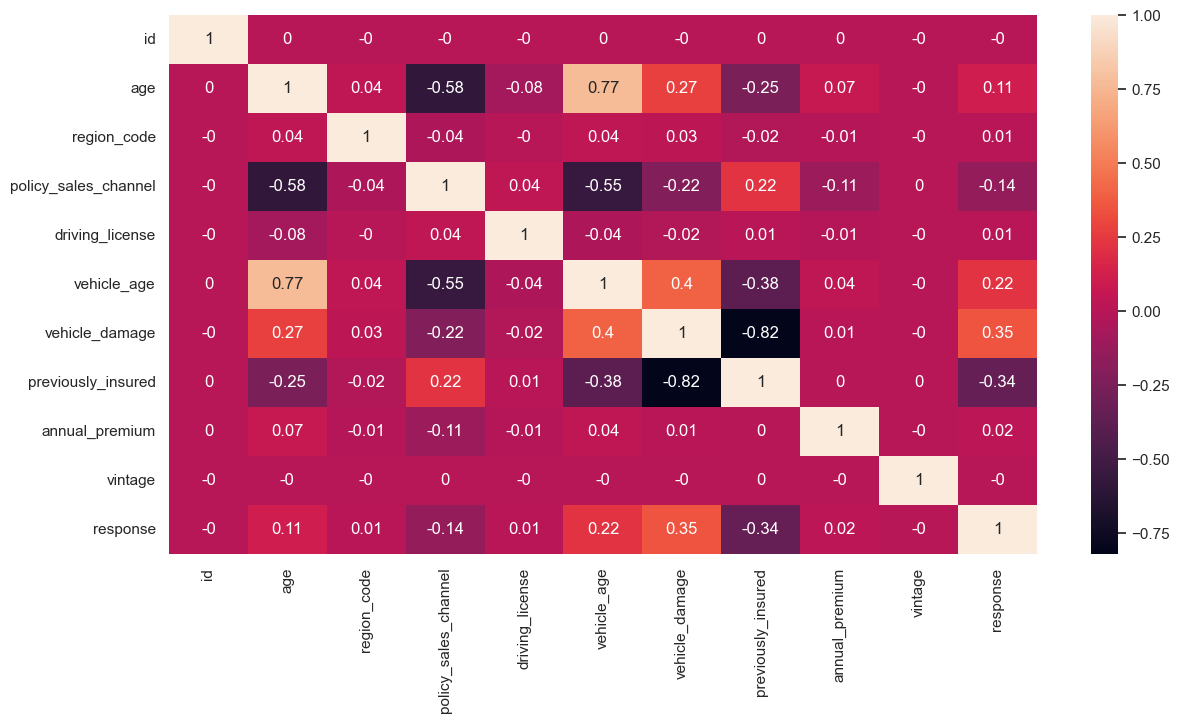

In [118]:
correlation = df2.corr().round(2)
plt.figure(figsize = (14,7))
sns.heatmap(correlation, annot = True)

## 5 - DATA PREPARATION

In [119]:
from feature_engine.transformation import PowerTransformer

In [120]:
from feature_engine.encoding import WoEEncoder

In [121]:
woe_encoder  = WoEEncoder(variables=['gender', 'vehicle_age', 'vehicle_damage'])
power_transform = PowerTransformer(variables=['id', 'age', 'region_code', 'policy_sales_channel', 'driving_license','previously_insured', 'annual_premium', 'vintage'])

### 5.1 - ML MODELS

In [122]:
# Parameter "scale_pos_weight" definition

from collections import Counter

# ESTIMATE SCALE_POS_WEIGHT
counter = Counter(y_train)
estimate = counter[0]/counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 7.144


#### Logistic Regression

In [123]:
# Model Definition
clf_lr = LogisticRegression()

In [125]:
# Pipeline
model_pipeline_lr = pipeline.Pipeline( steps = [("woe_encoder", woe_encoder),
                                                  ("power_transform", power_transform),
                                                  ("clf_lr", clf_lr)])

In [126]:
cross_validation(5, 'lr', model_pipeline_lr, x_train, y_train, 20000)

,lr
precision_at_k,0.2538
std_precision,+/-0.0012
recall_at_k,0.9041
std_recall,+/- 0.0042


In [127]:
model_pipeline_lr.fit(x_train, y_train)

Pipeline(steps=[('woe_encoder',
                 WoEEncoder(variables=['gender', 'vehicle_age',
                                       'vehicle_damage'])),
                ('power_transform',
                 PowerTransformer(variables=['id', 'age', 'region_code',
                                             'policy_sales_channel',
                                             'driving_license',
                                             'previously_insured',
                                             'annual_premium', 'vintage'])),
                ('clf_lr', LogisticRegression())])

In [130]:
yhat_lr_valid = model_pipeline_lr.predict_proba(x_valid)

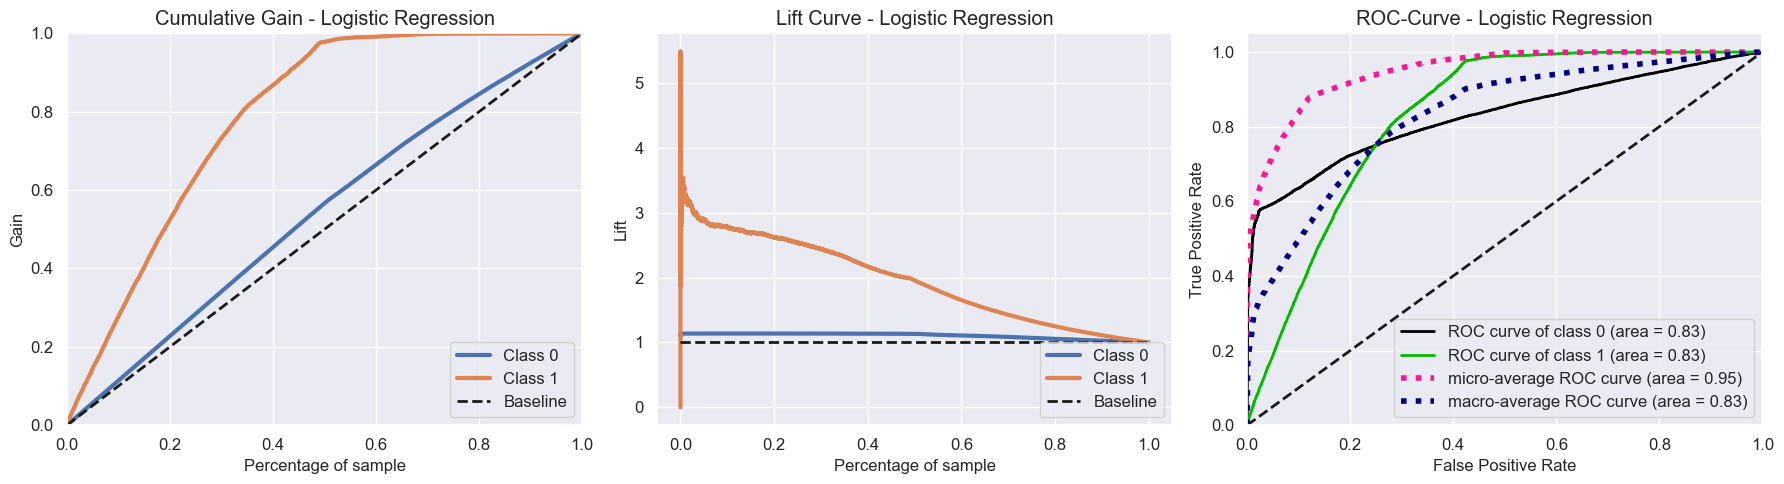

In [132]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_valid, yhat_lr_valid, ax=axs[0],title='Cumulative Gain - Logistic Regression');

# Lift Curve
skplt.metrics.plot_lift_curve(y_valid, yhat_lr_valid,ax=axs[1],title='Lift Curve - Logistic Regression');

# Roc Curve
skplt.metrics.plot_roc(y_valid, yhat_lr_valid, ax=axs[2], title='ROC-Curve - Logistic Regression');

plt.tight_layout()

In [133]:
# Precision and Recall @K
# As per Cumulative Gain chart, it is possible to identify that between 40% and 50% the model is able to find all interested customers.
aux = x_valid['id'].count()
k_value = 20000

precision_lr = precision_at_k_cv(y_valid, yhat_lr_valid, k_value)
recall_lr = recall_at_k_cv(y_valid, yhat_lr_valid, k_value)
LR_performance = ml_performance('LR', precision_lr, recall_lr )
LR_performance

,Model Name,Precision_at_K,Recall_at_K
0,LR,0.3054,0.659896


#### XGB

In [134]:
# Model Definition
clf_xgb = XGBClassifier(scale_pos_weight = estimate)

In [135]:
# Pipeline
model_pipeline_xgb = pipeline.Pipeline( steps = [("woe_encoder", woe_encoder),
                                                  ("power_transform", power_transform),
                                                  ("clf_xgb", clf_xgb)])

In [136]:
cross_validation(5, 'xgb', model_pipeline_xgb, x_train, y_train, 20000)

,xgb
precision_at_k,0.267
std_precision,+/-0.0007
recall_at_k,0.9511
std_recall,+/- 0.0024


In [137]:
model_pipeline_xgb.fit(x_train, y_train)

Pipeline(steps=[('woe_encoder',
                 WoEEncoder(variables=['gender', 'vehicle_age',
                                       'vehicle_damage'])),
                ('power_transform',
                 PowerTransformer(variables=['id', 'age', 'region_code',
                                             'policy_sales_channel',
                                             'driving_license',
                                             'previously_insured',
                                             'annual_premium', 'vintage'])),
                ('clf_xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=Non...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [138]:
yhat_xgb = model_pipeline_xgb.predict_proba(x_valid)

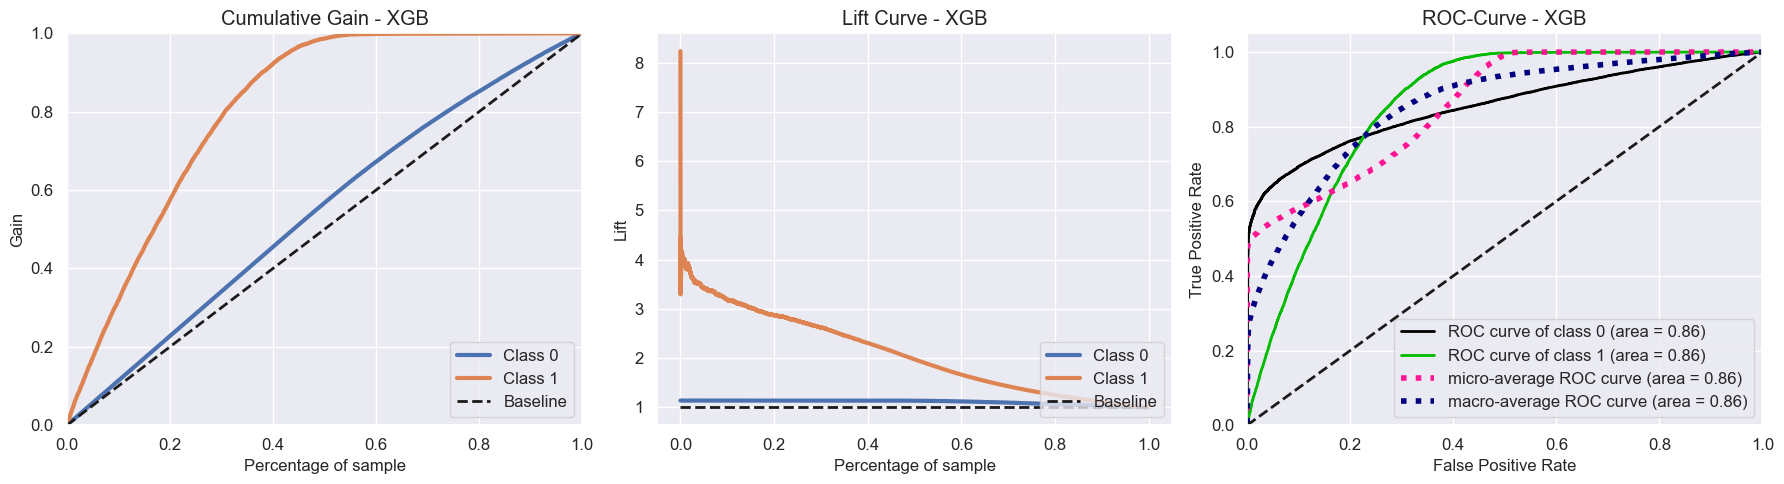

In [139]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_valid, yhat_xgb, ax=axs[0],title='Cumulative Gain - XGB');

# Lift Curve
skplt.metrics.plot_lift_curve(y_valid, yhat_xgb, ax=axs[1],title='Lift Curve - XGB');

# Roc Curve
skplt.metrics.plot_roc(y_valid, yhat_xgb, ax=axs[2], title='ROC-Curve - XGB');

plt.tight_layout()

In [140]:
# Precision and Recall @K

# As per Cumulative Gain chart, it is possible to identify that between 40% and 50% the model is able to find all interested customers.
aux = x_valid['id'].count()
k_value = 20000


precision_xgb = precision_at_k_cv(y_valid, yhat_xgb, k_value)
recall_xgb = recall_at_k_cv(y_valid, yhat_xgb, k_value)
XGB_performance = ml_performance('XGB', precision_xgb, recall_xgb )
XGB_performance

,Model Name,Precision_at_K,Recall_at_K
0,XGB,0.3308,0.71478


#### KNN

In [141]:
# Model Definition
clf_knn = KNeighborsClassifier( n_neighbors = 8 )

In [142]:
# Pipeline
model_pipeline_knn = pipeline.Pipeline( steps = [ ("woe_encoder", woe_encoder),
                                                  ("power_transform", power_transform),
                                                  ("clf_knn", clf_knn)])

In [143]:
cross_validation(5, 'knn', model_pipeline_knn, x_train, y_train, 20000)

,knn
precision_at_k,0.2211
std_precision,+/-0.0005
recall_at_k,0.7875
std_recall,+/- 0.0018


In [144]:
model_pipeline_knn.fit(x_train, y_train)

Pipeline(steps=[('woe_encoder',
                 WoEEncoder(variables=['gender', 'vehicle_age',
                                       'vehicle_damage'])),
                ('power_transform',
                 PowerTransformer(variables=['id', 'age', 'region_code',
                                             'policy_sales_channel',
                                             'driving_license',
                                             'previously_insured',
                                             'annual_premium', 'vintage'])),
                ('clf_knn', KNeighborsClassifier(n_neighbors=8))])

In [145]:
yhat_knn = model_pipeline_knn.predict_proba(x_valid)

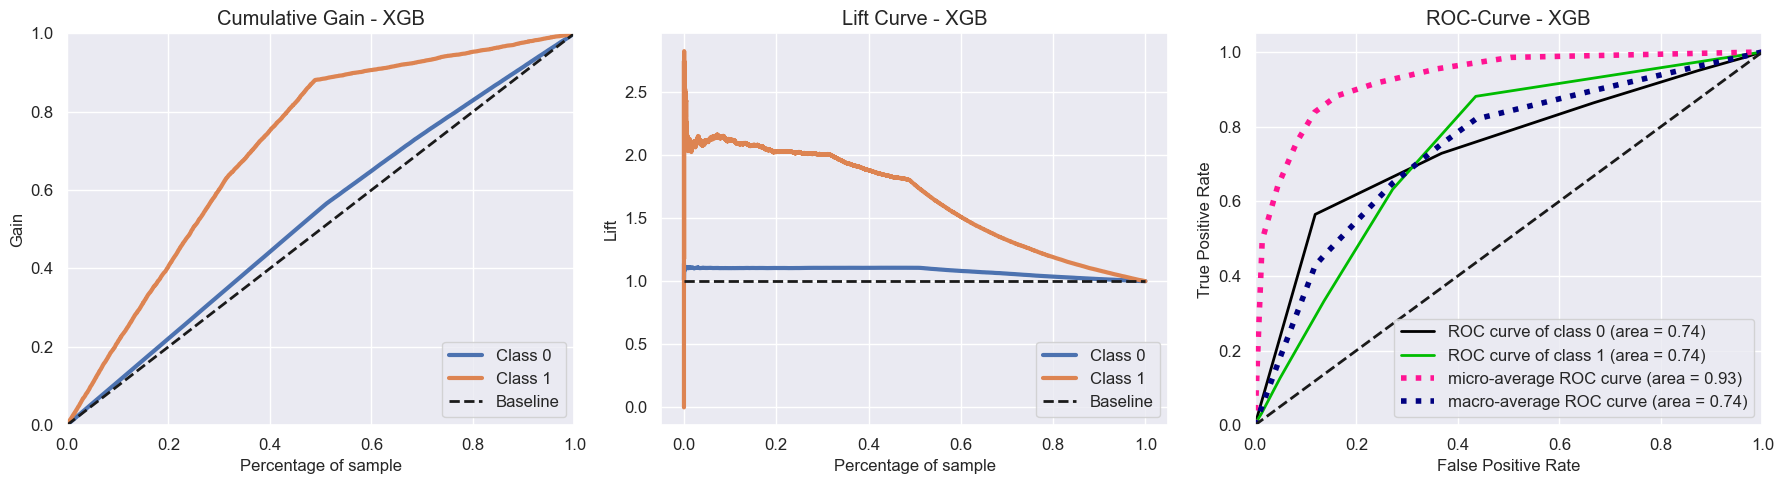

In [146]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_valid, yhat_knn, ax=axs[0],title='Cumulative Gain - XGB');

# Lift Curve
skplt.metrics.plot_lift_curve(y_valid, yhat_knn, ax=axs[1],title='Lift Curve - XGB');

# Roc Curve
skplt.metrics.plot_roc(y_valid, yhat_knn, ax=axs[2], title='ROC-Curve - XGB');

plt.tight_layout()

In [147]:
# Precision and Recall @K
k_value = 20000


precision_knn = precision_at_k_cv(y_valid, yhat_knn, k_value)
recall_knn = recall_at_k_cv(y_valid, yhat_knn, k_value)
KNN_performance = ml_performance('KNN', precision_knn, recall_knn )
KNN_performance

,Model Name,Precision_at_K,Recall_at_K
0,KNN,0.2444,0.52809


## 9 - HYPERPARAMETER FINE TUNING

### 9.1 - XGB Fine Tuning

In [148]:
# XGB
def objective_xgb(trial):
    """Define the objective function"""
    params = {
        'clf_xgb__max_depth': trial.suggest_int('clf_xgb__max_depth', 5, 20),
        'clf_xgb__eta': trial.suggest_float('clf_xgb__eta', 0.01, 0.05),
        'clf_xgb__learning_rate': trial.suggest_loguniform('clf_xgb__learning_rate', 0.01, 1.0),
        'clf_xgb__n_estimators': trial.suggest_int('clf_xgb__n_estimators', 100, 1000),
        'clf_xgb__min_child_weight': trial.suggest_int('clf_xgb__min_child_weight', 1, 15),
        'clf_xgb__gamma': trial.suggest_loguniform('clf_xgb__gamma', 1e-8, 1.0),
        'clf_xgb__subsample': trial.suggest_loguniform('clf_xgb__subsample', 0.01, 1.0),
        'clf_xgb__colsample_bytree': trial.suggest_loguniform('clf_xgb__colsample_bytree', 0.1, 1.0),
        'clf_xgb__reg_alpha': trial.suggest_loguniform('clf_xgb__reg_alpha', 1e-8, 1.0),
        'clf_xgb__reg_lambda': trial.suggest_loguniform('clf_xgb__reg_lambda', 1e-8, 1.0),
        'clf_xgb__eval_metric': 'mlogloss'
    }

    # Fit the model
    model_pipeline_xgb.set_params(**params)
    model_pipeline_xgb.fit(x_train, y_train)

    # Make predictions
    optuna_xgb_pred = model_pipeline_xgb.predict_proba(x_valid)

    # Evaluate predictions
    aux = x_valid['id'].count()
    k_value = round(0.4 * aux)
    k_value
    recall_atK = recall_at_k_cv(y_valid, optuna_xgb_pred, k_value)
    return  recall_atK

In [149]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=2)

[I 2023-09-18 20:53:24,133] A new study created in memory with name: no-name-b13451a6-70bc-43b5-9f9c-8bedc6d7520d
[I 2023-09-18 20:54:29,321] Trial 0 finished with value: 0.8296240276577356 and parameters: {'clf_xgb__max_depth': 14, 'clf_xgb__eta': 0.031562352971815644, 'clf_xgb__learning_rate': 0.2558185051744826, 'clf_xgb__n_estimators': 945, 'clf_xgb__min_child_weight': 14, 'clf_xgb__gamma': 0.005142465446252537, 'clf_xgb__subsample': 0.015203125274568064, 'clf_xgb__colsample_bytree': 0.35109121325716425, 'clf_xgb__reg_alpha': 1.6119666976725528e-07, 'clf_xgb__reg_lambda': 2.4209566608441117e-08}. Best is trial 0 with value: 0.8296240276577356.
[I 2023-09-18 20:54:53,422] Trial 1 finished with value: 0.9169187554019015 and parameters: {'clf_xgb__max_depth': 11, 'clf_xgb__eta': 0.01926118400249114, 'clf_xgb__learning_rate': 0.1678852089671428, 'clf_xgb__n_estimators': 406, 'clf_xgb__min_child_weight': 11, 'clf_xgb__gamma': 0.0004907120724916519, 'clf_xgb__subsample': 0.29465544833738

In [150]:
print('Number of finished trials: {}'.format(len(study_xgb.trials)))
print('Best trial:')
trial = study_xgb.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 2
Best trial:
  Value: 0.9169187554019015
  Params: 
    clf_xgb__max_depth: 11
    clf_xgb__eta: 0.01926118400249114
    clf_xgb__learning_rate: 0.1678852089671428
    clf_xgb__n_estimators: 406
    clf_xgb__min_child_weight: 11
    clf_xgb__gamma: 0.0004907120724916519
    clf_xgb__subsample: 0.29465544833738433
    clf_xgb__colsample_bytree: 0.12021037026944181
    clf_xgb__reg_alpha: 0.00019305357457998458
    clf_xgb__reg_lambda: 1.2593526921243355e-07


In [151]:
param_xgb = {'scale_pos_weight': estimate,
             'max_depth': 6,
             'eta': 0.0310260525237683,
             'learning_rate': 0.03914508739999509,
             'n_estimators': 619,
             'min_child_weight': 9,
             'gamma': 3.06408087126589e-05,
             'subsample': 0.3640515535413122,
             'colsample_bytree': 0.449945653612218,
             'reg_alpha': 0.143727642904309,
             'reg_lambda': 0.020464155005749916
            }

## 9.3 - ML Model After Tuning

In [152]:
x_lasttrain = pd.concat([x_train, x_valid], axis=0)
y_lasttrain = pd.concat([y_train, y_valid], axis=0)

### XGB After Tuning

In [153]:
# Model Definition
clf_xgb_ft = XGBClassifier(**param_xgb)


In [154]:
# Pipeline
model_pipeline_xgb_ft = pipeline.Pipeline( steps = [("woe_encoder", woe_encoder),
                                                   ("power_transform", power_transform),
                                                   ("clf_xgb_ft", clf_xgb_ft)])

In [155]:
model_pipeline_xgb_ft.fit(x_lasttrain, y_lasttrain)

Pipeline(steps=[('woe_encoder',
                 WoEEncoder(variables=['gender', 'vehicle_age',
                                       'vehicle_damage'])),
                ('power_transform',
                 PowerTransformer(variables=['id', 'age', 'region_code',
                                             'policy_sales_channel',
                                             'driving_license',
                                             'previously_insured',
                                             'annual_premium', 'vintage'])),
                ('clf_xgb_ft',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=...
                               gamma=3.06408087126589e-05, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.03914508739999509, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=6,
                               max_leaves=None, min_child_weight=9, missing=nan,
                               monotone_constraints=None, n_estimators=619,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, ...))])

In [156]:
yhat_xgb_ft = model_pipeline_xgb_ft.predict_proba(x_test)

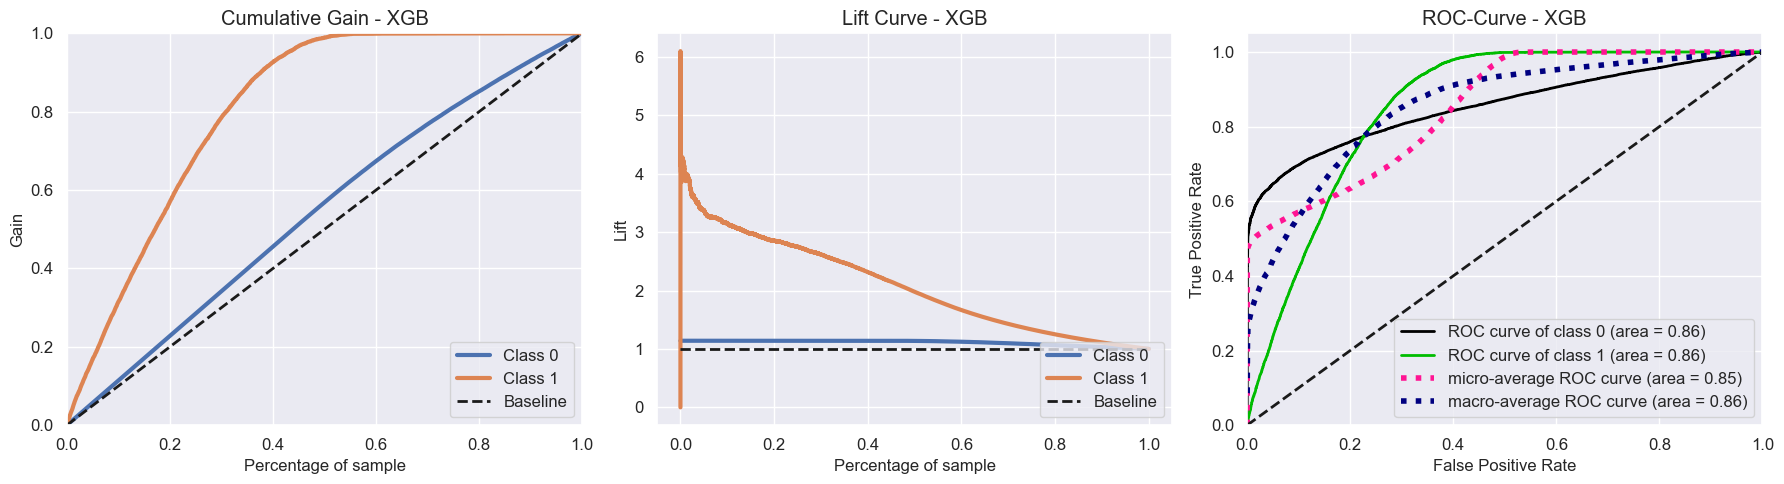

In [157]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_test, yhat_xgb_ft, ax=axs[0],title='Cumulative Gain - XGB');

# Lift Curve
skplt.metrics.plot_lift_curve(y_test, yhat_xgb_ft,ax=axs[1],title='Lift Curve - XGB');

# Roc Curve
skplt.metrics.plot_roc(y_test, yhat_xgb_ft, ax=axs[2], title='ROC-Curve - XGB');

plt.tight_layout()

In [158]:
# Precision and Recall @K
k_value = 20000


precision_xgb_ft = precision_at_k_cv(y_test, yhat_xgb_ft, k_value)
recall_xgb_ft = recall_at_k_cv(y_test, yhat_xgb_ft, k_value)
KNN_performance = ml_performance('XGB FT', precision_xgb_ft, recall_xgb_ft )
KNN_performance

,Model Name,Precision_at_K,Recall_at_K
0,XGB FT,0.33395,0.712351


In [159]:
# Precision and Recall @K
cross_validation(5, 'xgb_tuned', model_pipeline_xgb_ft, x_lasttrain, y_lasttrain, 20000)

,xgb_tuned
precision_at_k,0.3111
std_precision,+/-0.002
recall_at_k,0.8334
std_recall,+/- 0.0054


## 10 - DEPLOYING MODEL TO PRODUCTION

### 10.1 - HEALTHINSURANCE CLASS

In [ ]:
import pickle
import inflection
import numpy  as np
import pandas as pd

class HealthInsurance:
    
    def __init__( self ):
        self.home_path                                = ''
        self.frequency_encode_policy_sales_scaler     = pickle.load( open( self.home_path + 'src/features/frequency_encode_policy_sales_scaler.pkl', 'rb') )
        self.frequency_encode_region_code_scaler      = pickle.load( open( self.home_path + 'src/features/frequency_encode_region_code_scaler.pkl', 'rb') )
        self.target_encode_gender_scaler              = pickle.load( open( self.home_path + 'src/features/target_encode_gender_scaler.pkl', 'rb') )
        self.target_encode_vintage_month_scaler       = pickle.load( open( self.home_path + 'src/features/target_encode_vintage_month_scaler.pkl', 'rb') )
        self.age_scaler                               = pickle.load( open( self.home_path + 'src/features/age_scaler.pkl', 'rb') )
        self.avg_vehicle_damage_region_code_scaler    = pickle.load( open( self.home_path + 'src/features/age_scaler.pkl', 'rb') )
        self.avg_vintage_age_scaler                   = pickle.load( open( self.home_path + 'src/features/avg_vintage_age_scaler.pkl', 'rb') )
        self.vintage_scaler                           = pickle.load( open( self.home_path + 'src/features/vintage_scaler.pkl', 'rb') )
        self.age_premium_scaler                       = pickle.load( open( self.home_path + 'src/features/age_premium_scaler.pkl', 'rb') )
        self.annual_premium_scaler                    = pickle.load( open( self.home_path + 'src/features/age_premium_scaler.pkl', 'rb') )
        self.avg_day_premium_policy_scaler            = pickle.load( open( self.home_path + 'src/features/avg_day_premium_policy_scaler.pkl', 'rb') )
        self.day_premium_scaler                       = pickle.load( open( self.home_path + 'src/features/day_premium_scaler.pkl', 'rb') )
        self.median_premium_by_region_scaler          = pickle.load( open( self.home_path + 'src/features/median_premium_by_region_scaler.pkl', 'rb') )
        self.region_premium_scaler                    = pickle.load( open( self.home_path + 'src/features/region_premium_scaler.pkl', 'rb') )
    
    def data_cleaning( self, df5 ):
 
        ## rename Columns
        cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

        snakecase = lambda x: inflection.underscore( x )
        cols_new = list( map( snakecase, cols_old ) )
        
        # rename
        df5.columns = cols_new
        
        return( df5 )

    def feature_engineering( self, df5 ):
        
        # Fitting vehicle_age column
        df5['vehicle_age'] = df5['vehicle_age'].apply(lambda x: 1 if (x == '< 1 Year') else 2 if (x == '1-2 Year') else 3)

        # Fitting vehicle_damage column
        df5['vehicle_damage'] = df5['vehicle_damage'].apply(lambda x: 1 if (x == 'Yes') else 0)
        
        # median_premium_by_region
        dict_region_code = df5[['annual_premium', 'region_code']].groupby('region_code').median().to_dict(orient='dict')['annual_premium']
        df5['median_premium_by_region'] = df5['region_code'].map(dict_region_code)

        # moda policy sales chanel por idade
        mode_policy_per_age = df5[['age', 'policy_sales_channel']].groupby('age').agg(pd.Series.mode).to_dict(orient='dict')['policy_sales_channel']
        df5['mode_policy_per_age'] = df5['age'].map(mode_policy_per_age)

        # Media de carros danificados por idade
        avg_carros_danificados_idade = df5[['age', 'vehicle_damage']].groupby('age').mean().to_dict(orient='dict')['vehicle_damage']
        df5['avg_vehicle_damage_per_age'] = df5['age'].map(avg_carros_danificados_idade)

        # Media de carros danificados por regiao
        avg_carros_danificados_regiao = df5[['age', 'region_code']].groupby('age').mean().to_dict(orient='dict')['region_code']
        df5['avg_vehicle_damage_region_code'] = df5['age'].map(avg_carros_danificados_regiao)

        # age_group feature creation
        df5['age_group'] = df5['age'].apply(lambda x: 1 if (x >= 18 | x < 30 ) else 2 if (x >= 30 | x < 60 ) else 3)

        # vintage_month feature cration
        df5['vintage_month'] = round(df5['vintage'] / 31)

        # day_premium feature creation
        df5['day_premium'] = df5['annual_premium']/df5['vintage']

        # age_premium feature cration
        df5['age_premium'] = df5['annual_premium']/df5['age']

        # Calculating Median Annual Premium by Region_code
        premium_rc = df5[['annual_premium', 'region_code']].groupby('region_code').median().to_dict(orient='dict')['annual_premium']
        df5['region_premium'] = df5['region_code'].map(premium_rc)

        # Calculating Median Aday_premium per policy_sales_channel
        day_premium_psc = df5[['day_premium', 'policy_sales_channel']].groupby('policy_sales_channel').mean().to_dict(orient='dict')['day_premium']
        df5['avg_day_premium_policy'] = df5['policy_sales_channel'].map(day_premium_psc)

        # avg vintage per age
        avg_vintage_per_age = df5[['age', 'vintage']].groupby('age').mean().to_dict(orient='dict')['vintage']
        df5['avg_vintage_age'] = df5['age'].map(avg_vintage_per_age)
        
        return( df5 )
    
    def data_preparation( self, df5 ):
              
        # STANDARDIZATION

        # annual premium
        df5['annual_premium'] = self.annual_premium_scaler.transform( df5[['annual_premium']].values )

        # age_premium
        df5['age_premium'] = self.age_premium_scaler.transform( df5[['age_premium']].values )

        # day_premium
        df5['day_premium'] = self.day_premium_scaler.transform( df5[['day_premium']].values )

        # avg_day_premium_policy
        df5['avg_day_premium_policy'] = self.avg_day_premium_policy_scaler.transform( df5[['avg_day_premium_policy']].values )

        # median_premium_by_region
        df5['median_premium_by_region'] = self.median_premium_by_region_scaler.transform( df5[['median_premium_by_region']].values )

        # region_premium
        df5['region_premium'] = self.region_premium_scaler.transform( df5[['region_premium']].values )



        # REESCALING

        # age
        df5['age'] = self.age_scaler.transform( df5[['age']].values )

        # vintage
        df5['vintage'] = self.vintage_scaler.transform( df5[['vintage']].values )

        # avg_vintage_age
        df5['avg_vintage_age'] = self.avg_vintage_age_scaler.transform( df5[['avg_vintage_age']].values )

        # vintage_month
        df5['vintage_month'] = self.vintage_scaler.transform( df5[['vintage_month']].values )

        # avg_vehicle_damage_region_code
        df5['avg_vehicle_damage_region_code'] = self.avg_vehicle_damage_region_code_scaler.transform( df5[['avg_vehicle_damage_region_code']].values )



        # ENCODER

        # policy sales channel
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( self.frequency_encode_policy_sales_scaler )

        # region code
        df5.loc[:, 'region_code'] = df5['region_code'].map( self.frequency_encode_region_code_scaler )

        # gender
        df5.loc[:, 'gender'] = df5['gender'].map( self.target_encode_gender_scaler )

        # vintage_month
        df5.loc[:, 'vintage_month'] = df5['vintage_month'].map( self.target_encode_vintage_month_scaler )

        # FILL NAN VALUES
        x_valid = x_valid.fillna(0)
        
        # Feature Selection
        cols_selected = ['vehicle_damage','previously_insured','vintage','day_premium','age_premium','annual_premium','vintage_month','region_code','avg_vehicle_damage_per_age','policy_sales_channel','age','median_premium_by_region','region_premium',
                         'avg_day_premium_policy','vehicle_age','avg_vehicle_damage_region_code','avg_vintage_age','gender']
        
        return df5[cols_selected]
    

    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict_proba( test_data )
        
        # join pred into the original data
        original_data['score'] = pred[:, 1].tolist()
        
        return original_data.to_json( orient='records', date_format='iso' )

### 10.2 - API HANDLER

In [ ]:
import pickle
import pandas as pd
import os
from flask                           import Flask, request, Response
from healthinsurance.healthinsurance import HealthInsurance

# logading model
model = pickle.load( open( 'src/models/xgb_model.pkl', 'rb' ) )
                          
# initialize API
app = Flask( __name__ )

@app.route( '/healthinsurance/predict', methods=['POST'] )
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json: #there is data
               
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
    
        else:
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() ) # multiple examples
            
        # Instantiate Rossmann Class
        pipeline = HealthInsurance()

        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
              
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )

        # Data Preparation
        df3 = pipeline.data_preparation( df2 )
                              
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run('0.0.0.0')

#    port = os.environ.get('PORT', 5000)
#    app.run( host='0.0.0.0', port=port )

## 11 - BUSINESS QUESTIONS

In [ ]:
df_11 = pd.concat([x_test, y_test], axis=1)

In [ ]:
df_11['prediction'] = yhat_lgbm_ft[:,1]

In [ ]:
df_11.head()

### 1 - What percentage of customers interested in purchasing a car insurance will the sales team be able to contact by making 20,000 calls?

In [ ]:
n = 20000
ax1 = df_11['id'][(df_11['prediction'] > 0.5)].count()
q1 = df_11.sort_values(by='prediction', ascending=False)
ax2 = q1.iloc[:20000]
ax3 = (ax2['response'] == 1).sum()
ax4 = (df_11['response'] == 1).sum()

print(f'Numbers os contacts: {n} ({n/len(df_11):.2%})')
print(f'Will impact {ax3/ax4:.2%} of interested customers')

### 2 -  And if the sales team's capacity increases to 40,000 calls, what percentage of customers interested in purchasing a car insurance will the sales team be able to contact?

In [ ]:
n = 40000
ax1 = df_11['id'][(df_11['prediction'] > 0.5)].count()
q1 = df_11.sort_values(by='prediction', ascending=False)
ax2 = q1.iloc[:40000]
ax3 = (ax2['response'] == 1).sum()
ax4 = (df_11['response'] == 1).sum()

print(f'Numbers os contacts: {n} ({n/len(df_11):.2%})')
print(f'Will impact {ax3/ax4:.2%} of interested customers')

### 3 - How many calls does the sales team need to make to contact 80% of customers interested in purchasing a car insurance?

In [ ]:
n = 20000
ax1 = df_11['id'][(df_11['prediction'] > 0.5)].count()
q1 = df_11.sort_values(by='prediction', ascending=False)
ax2 = q1.iloc[:23500]
ax3 = (ax2['response'] == 1).sum()
ax4 = (df_11['response'] == 1).sum()

print(f'Numbers os contacts: {n} ({n/len(df_11):.2%})')
print(f'Will impact {ax3/ax4:.2%} of interested customers')